In [471]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.table import Table
from mpl_toolkits.axes_grid1.inset_locator import inset_axes,zoomed_inset_axes

%matplotlib notebook

In [116]:
ps1_white_phot = fits.getdata("COSMOS_compare_white_phot_adamamiller.fit")

The first step is to create some filters so that apples to apples comparisons can be done between the 3 different photometry methods from PS1.

In [117]:
print("Of the {:d} unique sources in the COSMOS cross-match:".format(len(ps1_white_phot)))
print("\tThere are {:d} sources with Mean white phot,".format(sum(~np.isnan(ps1_white_phot["wwMeanPSFKronRatio"]))))
print("\tThere are {:d} sources with Forced white phot,".format(sum(~np.isnan(ps1_white_phot["wwFPSFKronRatio"]))))
print("\tThere are {:d} sources with Stacked white phot.".format(sum(~np.isnan(ps1_white_phot["wwPSFKronRatio"]))))

Of the 80974 unique sources in the COSMOS cross-match:
	There are 42784 sources with Mean white phot,
	There are 80880 sources with Forced white phot,
	There are 76083 sources with Stacked white phot.


In [520]:
det_mfs = np.where(np.isfinite(ps1_white_phot["wwMeanPSFKronRatio"]) & 
                   np.isfinite(ps1_white_phot["wwFPSFKronRatio"]) & 
                   np.isfinite(ps1_white_phot["wwPSFKronRatio"]))
det_mfs_star = np.where(np.isfinite(ps1_white_phot["wwMeanPSFKronRatio"]) & 
                        np.isfinite(ps1_white_phot["wwFPSFKronRatio"]) & 
                        np.isfinite(ps1_white_phot["wwPSFKronRatio"]) & 
                        (ps1_white_phot["mu_class"] == 2) &
                        (ps1_white_phot["wwMeanPSFKronRatio"] <= 2.0))
det_mfs_gal = np.where(np.isfinite(ps1_white_phot["wwMeanPSFKronRatio"]) & 
                        np.isfinite(ps1_white_phot["wwFPSFKronRatio"]) & 
                        np.isfinite(ps1_white_phot["wwPSFKronRatio"]) & 
                        (ps1_white_phot["mu_class"] == 1) &
                        (ps1_white_phot["wwMeanPSFKronRatio"] <= 2.0))

det_fs = np.where(np.isfinite(ps1_white_phot["wwFPSFKronRatio"]) & 
                  np.isfinite(ps1_white_phot["wwPSFKronRatio"]))
det_fs_star = np.where(np.isfinite(ps1_white_phot["wwFPSFKronRatio"]) & 
                       np.isfinite(ps1_white_phot["wwPSFKronRatio"]) & 
                       (ps1_white_phot["mu_class"] == 2) )
det_fs_gal = np.where(np.isfinite(ps1_white_phot["wwFPSFKronRatio"]) & 
                      np.isfinite(ps1_white_phot["wwPSFKronRatio"]) & 
                      (ps1_white_phot["mu_class"] == 1) )

/Users/adamamiller/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in less_equal
/Users/adamamiller/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:13: RuntimeWarning: invalid value encountered in less_equal


# Part 1 - Bright Sources Detected in Single Exposures

## Plot distance vs. Kron mag for 3 different phot measures

Show the distribution of these sources in their respective PSF vs. Kron planes.

In [52]:
# import seaborn as sns

In [323]:
ps1_df = Table.read("COSMOS_compare_white_phot_adamamiller.fit").to_pandas()

ps1_df["MeanDist"] = (ps1_white_phot["wwMeanPSFFlux"] - ps1_white_phot["wwMeanKronFlux"])/np.sqrt(2)
ps1_df["FDist"] = (ps1_white_phot["wwFPSFFlux"] - ps1_white_phot["wwFKronFlux"])/np.sqrt(2)
ps1_df["Dist"] = (ps1_white_phot["wwPSFFlux"] - ps1_white_phot["wwKronFlux"])/np.sqrt(2)

ps1_df["MeanKronMag"] = -2.5*np.log10(ps1_white_phot["wwMeanKronFlux"]/3631)
ps1_df["FKronMag"] = -2.5*np.log10(ps1_white_phot["wwFKronFlux"]/3631)
ps1_df["KronMag"] = -2.5*np.log10(ps1_white_phot["wwKronFlux"]/3631)


In [327]:
from statsmodels.nonparametric.kernel_density import KDEMultivariate
import statsmodels.nonparametric.api as smnp

def kde_contour_dat(x, y, extent = (0,0,0,0), bw_type = "silverman", grid_bins = 100):
    """Determine normalized KDE PDF to draw contours"""
    
    if isinstance(x, pd.Series):
        x = x.values
    if isinstance(y, pd.Series):
        y = y.values
    
    if extent == (0,0,0,0):
        extent = (x.min(), x.max(), y.min(), y.max())

    if bw_type == "silverman":
        bw = np.array([smnp.bandwidths.bw_silverman(x), smnp.bandwidths.bw_silverman(y)])
    elif bw_type == "scott":
        bw = np.array([smnp.bandwidths.bw_scott(x), smnp.bandwidths.bw_scott(y)])

    kde = KDEMultivariate([x,y], var_type='cc', bw = bw)

    xi, yi = np.mgrid[extent[0]:extent[1]:grid_bins*1j,extent[2]:extent[3]:grid_bins*1j]

    kde_prob = kde.pdf(np.vstack([xi.flatten(), yi.flatten()]))

    zi = (kde_prob-kde_prob.min())/(kde_prob.max() - kde_prob.min())
    zi = zi.reshape(xi.shape)

    return xi, yi, zi

In [ ]:
gal_dist_mean = ps1_df.ix[det_mfs_gal]["MeanDist"]
gal_mag_mean = ps1_df.ix[det_mfs_gal]["MeanKronMag"]

star_dist_mean = ps1_df.ix[det_mfs_star]["MeanDist"]
star_mag_mean = ps1_df.ix[det_mfs_star]["MeanKronMag"]

xgal_mean, ygal_mean, zgal_mean = kde_contour_dat(gal_mag_mean, gal_dist_mean, extent = (16,24,-2e-5,2e-5))
xstar_mean, ystar_mean, zstar_mean = kde_contour_dat(star_mag_mean, star_dist_mean, extent = (16,24,-2e-5,2e-5))

gal_dist_forced = ps1_df.ix[det_mfs_gal]["FDist"]
gal_mag_forced = ps1_df.ix[det_mfs_gal]["FKronMag"]

star_dist_forced = ps1_df.ix[det_mfs_star]["FDist"]
star_mag_forced = ps1_df.ix[det_mfs_star]["FKronMag"]

xgal_forced, ygal_forced, zgal_forced = kde_contour_dat(gal_mag_forced, gal_dist_forced, extent = (16,24,-2e-5,2e-5))
xstar_forced, ystar_forced, zstar_forced = kde_contour_dat(star_mag_forced, star_dist_forced, extent = (16,24,-2e-5,2e-5))

gal_dist_stacked = ps1_df.ix[det_mfs_gal]["Dist"]
gal_mag_stacked = ps1_df.ix[det_mfs_gal]["KronMag"]

star_dist_stacked = ps1_df.ix[det_mfs_star]["Dist"]
star_mag_stacked = ps1_df.ix[det_mfs_star]["KronMag"]

xgal_stacked, ygal_stacked, zgal_stacked = kde_contour_dat(gal_mag_stacked, gal_dist_stacked, extent = (16,24,-2e-5,2e-5))
xstar_stacked, ystar_stacked, zstar_stacked = kde_contour_dat(star_mag_stacked, star_dist_stacked, extent = (16,24,-2e-5,2e-5))

<IPython.core.display.Javascript object>


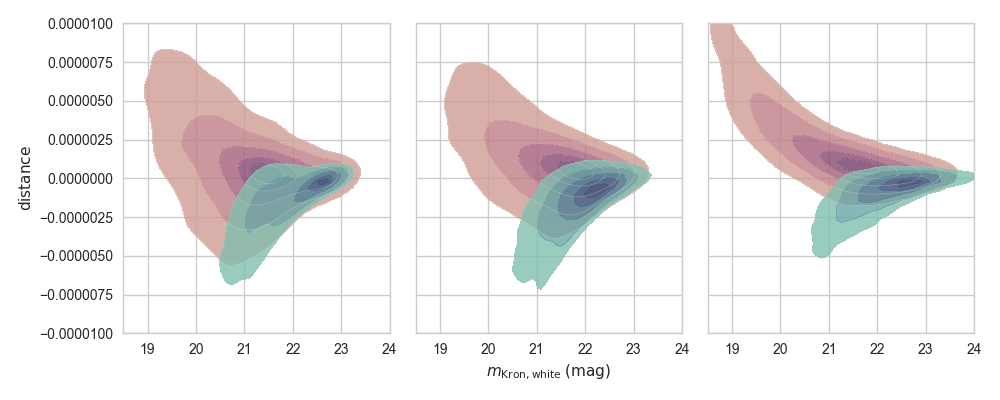

In [340]:
origin = 'lower'
levels = [0.1, 0.25, 0.5, 0.75, 0.9,1]
cmap_star = sns.cubehelix_palette(rot=0.5, light=0.7,dark=0.3,as_cmap=True)
cmap_gal = sns.cubehelix_palette(start=0.3,rot=-0.5,light=0.7,dark=0.3,as_cmap=True)

with sns.axes_style("whitegrid"):
    fig, axes = plt.subplots(1, 3, sharex=True, sharey=True, figsize = (10, 4))
    for axnum, (xstar, ystar, zstar, xgal, ygal, zgal) in enumerate([(xstar_mean, ystar_mean, zstar_mean, xgal_mean, ygal_mean, zgal_mean), 
                                                                     (xstar_forced, ystar_forced, zstar_forced, xgal_forced, ygal_forced, zgal_forced), 
                                                                     (xstar_stacked, ystar_stacked, zstar_stacked,xgal_stacked, ygal_stacked, zgal_stacked)]):
        axes[axnum].contourf(xstar, ystar, zstar, levels = levels,
                             origin = origin,
                             cmap = cmap_star, alpha = 0.8)
        axes[axnum].contour(xstar, ystar, zstar, levels = levels,
                            linewidths=(0.3,), origin = origin,
                            colors = ("w",), alpha = 0.5, zorder = 11)
        axes[axnum].contourf(xgal, ygal, zgal, levels = levels,
                             origin = origin, 
                             cmap = cmap_gal, alpha = 0.8, zorder = 10)
        axes[axnum].contour(xgal, ygal, zgal, levels = levels,
                            linewidths=(0.5,), origin = origin, 
                            colors = ("w",), alpha = 0.5)

    axes[axnum].set_xlim(18.5, 24)
    axes[axnum].set_ylim(-1e-5, 1e-5)
    axes[1].set_xlabel(r"$m_\mathrm{Kron,white}\;(\mathrm{mag})$")
    axes[0].set_ylabel(r"$\mathrm{distance}$")
    fig.tight_layout()

## Determine the combo of data + slope to maximize TPR at FPR = 0.005

There are 4 numerical quantities that we care about, though ultimately we hope to maximize the TPR at FPR = 0.005.

In [445]:
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score

def calc_distance(a, x, y): # model: y = ax
    a = np.array(a)
    model = (a*x).astype(float)
    wd = (y-model)/np.sqrt(1 + a**2)
    return np.array(wd)

def calc_accuracy(a, flux1, flux2, true_class):
    a = np.array(a)
    delta = calc_distance(a, flux1, flux2)
    pred_class = np.array((np.sign(delta)+1)/2, dtype = int)    # psf = kron >> gal
    acc = accuracy_score(true_class, pred_class)
    return acc

def calc_roc_auc(a, flux1, flux2, true_class): 
    a = np.array(a)
    delta = calc_distance(a, flux1, flux2)
    auc = roc_auc_score(true_class, delta)
    return auc

def calc_informedness_and_tpr(a, flux1, flux2, true_class): 
    a = np.array(a)
    delta = calc_distance(a, flux1, flux2)
    fpr, tpr, thre = roc_curve(true_class, delta)
    tpr_at_fpr005 = tpr[np.argmin(np.abs(fpr - 0.005))]
    return np.max(tpr-fpr), tpr_at_fpr005

def calc_roc_curve(a, flux1, flux2, true_class): 
    a = np.array(a)
    delta = calc_distance(a, flux1, flux2)
    fpr, tpr, thre = roc_curve(true_class, delta)    
    return fpr, tpr, thre

In [407]:
a_grid = np.linspace(0, 2, 101)

for phot, wwphot in zip(["mean", "forced", "stacked"],
                        ["wwMean", "wwF", "ww"]):

    exec("acc_{:s} = np.empty(len(a_grid))".format(phot))
    exec("auc_{:s} = np.empty(len(a_grid))".format(phot))
    exec("inform_{:s} = np.empty(len(a_grid))".format(phot))
    exec("fom_{:s} = np.empty(len(a_grid))".format(phot))

    for i_a, a in enumerate(a_grid):
        exec("""acc_{:s}[i_a] = calc_accuracy(a, ps1_df.ix[det_mfs]['{:s}KronFlux'], 
                                      ps1_df.ix[det_mfs]['{:s}PSFFlux'], 
                                      np.array(ps1_df.ix[det_mfs]['mu_class'], dtype = int)-1)""".format(phot, wwphot, wwphot))
        exec("""auc_{:s}[i_a] = calc_roc_auc(a, ps1_df.ix[det_mfs]["{:s}KronFlux"], 
                                      ps1_df.ix[det_mfs]["{:s}PSFFlux"], 
                                      np.array(ps1_df.ix[det_mfs]["mu_class"], dtype = int)-1)""".format(phot, wwphot, wwphot))
        exec("""inform_{:s}[i_a], fom_{:s}[i_a] = calc_informedness_and_tpr(a, ps1_df.ix[det_mfs]['{:s}KronFlux'], 
                                      ps1_df.ix[det_mfs]['{:s}PSFFlux'], 
                                      np.array(ps1_df.ix[det_mfs]['mu_class'], dtype = int)-1)""".format(phot, phot, wwphot, wwphot))

<IPython.core.display.Javascript object>


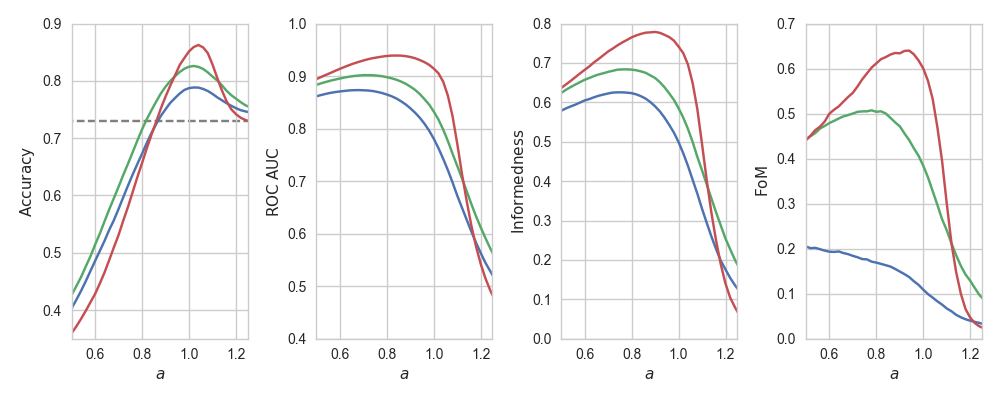

Max Acc = 0.8625 at a = 1.0400
Max AUC = 0.9390 at a = 0.8400
Max TPR-FPR = 0.7785 at a = 0.9000
Max FoM = 0.6398 at a = 0.9400


In [444]:
with sns.axes_style("whitegrid"):
    fig, axes = plt.subplots(1, 4, sharex=True, figsize=(10,4))
    for phot in ["mean", "forced", "stacked"]:
        exec("axes[0].plot(a_grid, acc_{:s})".format(phot))
        exec("axes[1].plot(a_grid, auc_{:s})".format(phot))
        exec("axes[2].plot(a_grid, inform_{:s})".format(phot))
        exec("axes[3].plot(a_grid, fom_{:s})".format(phot))

    axes[3].set_xlim(0.5,1.25)

    for ax, ylims, ylabel in zip(axes, 
                                 [(0.35,0.9),(0.4,1),(0,0.8),(0,0.7)],
                                 [r"$\mathrm{Accuracy}$", r"$\mathrm{ROC \; AUC}$",
                                  r"$\mathrm{Informedness}$", r"$\mathrm{FoM}$"]):
        ax.set_ylim(ylims)
        ax.set_ylabel(ylabel)
        ax.set_xlabel(r"$a$")
    axes[0].plot([0,2], [0.73, 0.73], '--', 
                 color = '0.5', zorder = -4)
    fig.tight_layout()

print("Max Acc = {:.4f} at a = {:.4f}".format(max(acc_stacked), 
                                              a_grid[np.argmax(acc_stacked)]))
print("Max AUC = {:.4f} at a = {:.4f}".format(max(auc_stacked), 
                                              a_grid[np.argmax(auc_stacked)]))
print("Max TPR-FPR = {:.4f} at a = {:.4f}".format(max(inform_stacked), 
                                                  a_grid[np.argmax(inform_stacked)]))
print("Max FoM = {:.4f} at a = {:.4f}".format(max(fom_stacked), 
                                              a_grid[np.argmax(fom_stacked)]))

Given that the dataset is dominated by faint sources, it should perhaps not be surprising that the PS1 stacked photometry clearly outperforms the other photometric methods (which have known issues at fainter brightness levels). 

Also interesting is that $a \approx 1$ maximizes each of the metrics that we are interested in determining. For the FoM, the variation near peak is strongly dependent on the selected value of $a$ - **the choice of this value should be confirmed via cross-validation.**

Below, we show that adopting $a = 0.94$ does not strongly degrade the other metrics considered for the simple model. Less than 1% for the ROC stats, and 6% for the accuracy (in particular this last choice leads to 

In [438]:
print("Delta acc = {:.4f}".format((acc_stacked[np.argmax(fom_stacked)] - max(acc_stacked))/max(acc_stacked)))
print("Delta auc = {:.4f}".format((auc_stacked[np.argmax(fom_stacked)] - max(auc_stacked))/max(auc_stacked)))
print("Delta inform = {:.4f}".format((inform_stacked[np.argmax(fom_stacked)] - max(inform_stacked))/max(inform_stacked)))

Delta acc = -0.0618
Delta auc = -0.0091
Delta inform = -0.0093


Having established that the stacked photometry is the best for PS1, we now examine the ROC curves for the four different metrics considered above.

<IPython.core.display.Javascript object>


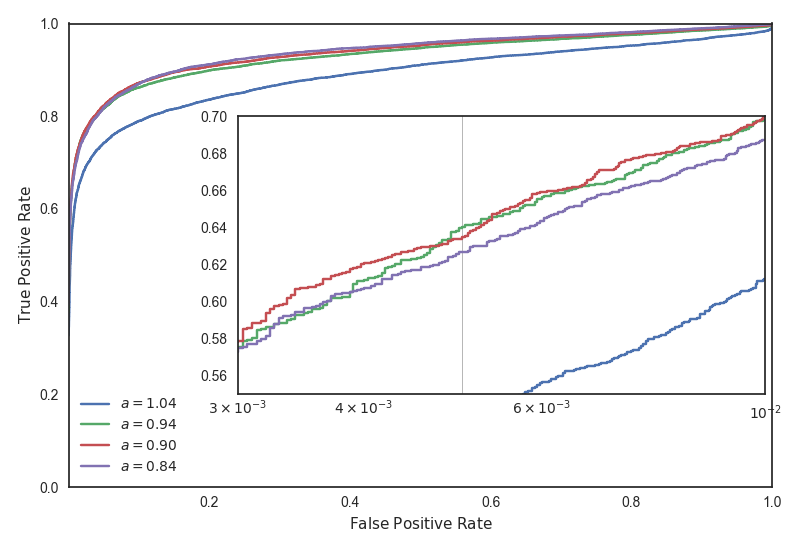

/Users/adamamiller/miniconda3/envs/py36/lib/python3.6/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


In [494]:
a_choice = [1.04, 0.94, 0.90, 0.84]

fig, ax = plt.subplots()

axins = inset_axes(ax, width="75%",  
                   height="60%", loc=7)

for a in a_choice:
    fpr, tpr, thre = calc_roc_curve(a, ps1_df.ix[det_mfs]["wwKronFlux"], 
                                    ps1_df.ix[det_mfs]["wwPSFFlux"], 
                                    np.array(ps1_df.ix[det_mfs]["mu_class"], dtype = int)-1)
    ax.plot(fpr, tpr, label = r"$a = {:.2f}$".format(a))
    axins.plot(fpr, tpr)

axins.plot([5e-3,5e-3], [0,1], '0.6', lw = 0.5, zorder = -10)
    
# ax.set_yscale("log")
# ax.set_xscale("log")
ax.set_xlim(1e-3,1)
ax.set_ylim(1e-3,1)
ax.set_xlabel(r"$\mathrm{False\;Positive\;Rate}$")
ax.set_ylabel(r"$\mathrm{True\;Positive\;Rate}$")

axins.set_xlim(3e-3, 1e-2)
axins.set_ylim(0.55, 0.7)
axins.set_xscale("log")
# axins.set_yscale("log")
# axins.set_xlabel(r"$\mathrm{FPR}$")
# axins.set_ylabel(r"$\mathrm{TPR}$")

ax.legend()
fig.tight_layout()

From the ROC curves, it is clear that the performance at $a = 0.90$ is better than the FoM maximizing $a = 0.94$, aside from a small (noise?) spike exactly at FPR = 0.005. *This result should still be confirmed via CV or independent train-test split.*

**Thus, we adpot $a = 0.90$ as the optimal threshold for classifying PS1 stars and galaxies.**

To obtain FPR = 0.005 from this model requires a threshold of:

In [501]:
a = 0.90
fpr, tpr, thre = calc_roc_curve(a, ps1_df.ix[det_mfs]["wwKronFlux"], 
                                ps1_df.ix[det_mfs]["wwPSFFlux"], 
                                np.array(ps1_df.ix[det_mfs]["mu_class"], dtype = int)-1)
print("Sources with d > {:.8f} should be classified as stars".format(thre[np.argmin(np.abs(fpr - 0.005))]))


Sources with d > 0.00000185 should be classified as stars


# Part 2 - checking even the faintest sources

Below we will execute the same analysis, but this time using only sources detected in both the Forced and Stacked photometry from PS1. The primary difference for this sample is that it is a factor of $\sim$2 larger because the depth limits of the PS1 mean photometry are $\sim$1 mag more shallow than Forced and Stacked.

In [521]:
gal_dist_forced = ps1_df.ix[det_fs_gal]["FDist"]
gal_mag_forced = ps1_df.ix[det_fs_gal]["FKronMag"]

star_dist_forced = ps1_df.ix[det_fs_star]["FDist"]
star_mag_forced = ps1_df.ix[det_fs_star]["FKronMag"]

xgal_forced, ygal_forced, zgal_forced = kde_contour_dat(gal_mag_forced, gal_dist_forced, extent = (17,25.5,-4e-5,4e-5))
xstar_forced, ystar_forced, zstar_forced = kde_contour_dat(star_mag_forced, star_dist_forced, extent = (17,25.5,-4e-5,4e-5))

gal_dist_stacked = ps1_df.ix[det_fs_gal]["Dist"]
gal_mag_stacked = ps1_df.ix[det_fs_gal]["KronMag"]

star_dist_stacked = ps1_df.ix[det_fs_star]["Dist"]
star_mag_stacked = ps1_df.ix[det_fs_star]["KronMag"]

xgal_stacked, ygal_stacked, zgal_stacked = kde_contour_dat(gal_mag_stacked, gal_dist_stacked, extent = (17,25.5,-4e-5,4e-5))
xstar_stacked, ystar_stacked, zstar_stacked = kde_contour_dat(star_mag_stacked, star_dist_stacked, extent = (17,25.5,-4e-5,4e-5))

<IPython.core.display.Javascript object>


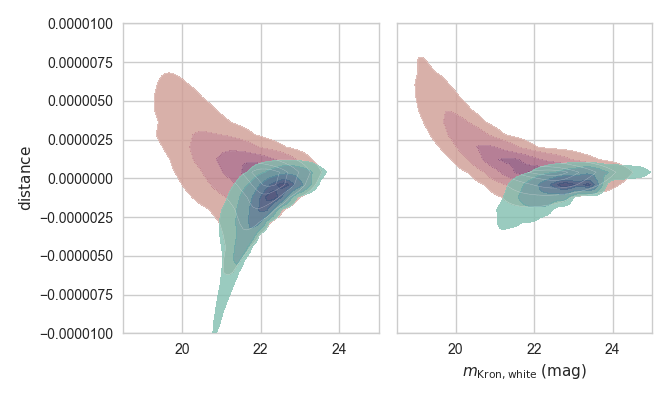

In [525]:
origin = 'lower'
levels = [0.1, 0.25, 0.5, 0.75, 0.9,1]
cmap_star = sns.cubehelix_palette(rot=0.5, light=0.7,dark=0.3,as_cmap=True)
cmap_gal = sns.cubehelix_palette(start=0.3,rot=-0.5,light=0.7,dark=0.3,as_cmap=True)

with sns.axes_style("whitegrid"):
    fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize = (6.7, 4))
    for axnum, (xstar, ystar, zstar, xgal, ygal, zgal) in enumerate([(xstar_forced, ystar_forced, zstar_forced, 
                                                                      xgal_forced, ygal_forced, zgal_forced), 
                                                                     (xstar_stacked, ystar_stacked, zstar_stacked,
                                                                      xgal_stacked, ygal_stacked, zgal_stacked)]):
        axes[axnum].contourf(xstar, ystar, zstar, levels = levels,
                             origin = origin,
                             cmap = cmap_star, alpha = 0.8)
        axes[axnum].contour(xstar, ystar, zstar, levels = levels,
                            linewidths=(0.3,), origin = origin,
                            colors = ("w",), alpha = 0.5, zorder = 11)
        axes[axnum].contourf(xgal, ygal, zgal, levels = levels,
                             origin = origin, 
                             cmap = cmap_gal, alpha = 0.8, zorder = 10)
        axes[axnum].contour(xgal, ygal, zgal, levels = levels,
                            linewidths=(0.5,), origin = origin, 
                            colors = ("w",), alpha = 0.5)

    axes[axnum].set_xlim(18.5, 25)
    axes[axnum].set_ylim(-1e-5, 1e-5)
    axes[1].set_xlabel(r"$m_\mathrm{Kron,white}\;(\mathrm{mag})$")
    axes[0].set_ylabel(r"$\mathrm{distance}$")
    fig.tight_layout()

In [526]:
a_grid = np.linspace(0, 2, 101)

for phot, wwphot in zip(["forced", "stacked"],
                        ["wwF", "ww"]):

    exec("acc_{:s} = np.empty(len(a_grid))".format(phot))
    exec("auc_{:s} = np.empty(len(a_grid))".format(phot))
    exec("inform_{:s} = np.empty(len(a_grid))".format(phot))
    exec("fom_{:s} = np.empty(len(a_grid))".format(phot))

    for i_a, a in enumerate(a_grid):
        exec("""acc_{:s}[i_a] = calc_accuracy(a, ps1_df.ix[det_fs]['{:s}KronFlux'], 
                                      ps1_df.ix[det_fs]['{:s}PSFFlux'], 
                                      np.array(ps1_df.ix[det_fs]['mu_class'], dtype = int)-1)""".format(phot, wwphot, wwphot))
        exec("""auc_{:s}[i_a] = calc_roc_auc(a, ps1_df.ix[det_fs]["{:s}KronFlux"], 
                                      ps1_df.ix[det_fs]["{:s}PSFFlux"], 
                                      np.array(ps1_df.ix[det_fs]["mu_class"], dtype = int)-1)""".format(phot, wwphot, wwphot))
        exec("""inform_{:s}[i_a], fom_{:s}[i_a] = calc_informedness_and_tpr(a, ps1_df.ix[det_fs]['{:s}KronFlux'], 
                                      ps1_df.ix[det_fs]['{:s}PSFFlux'], 
                                      np.array(ps1_df.ix[det_fs]['mu_class'], dtype = int)-1)""".format(phot, phot, wwphot, wwphot))

<IPython.core.display.Javascript object>


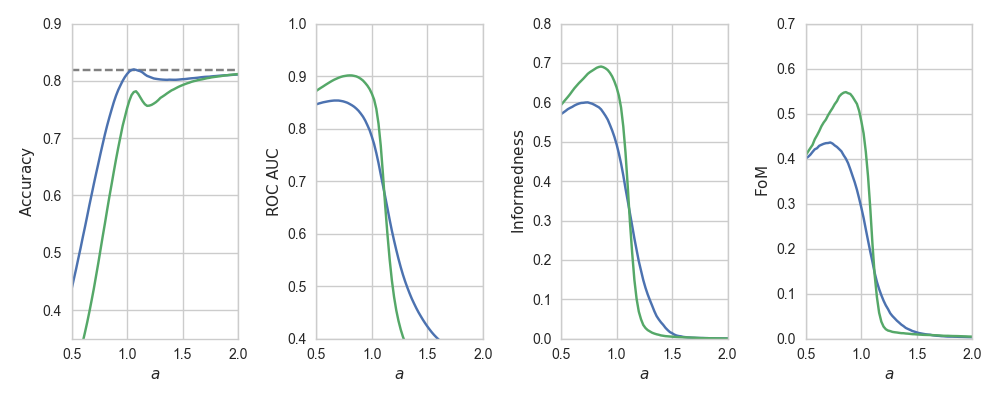

Max Acc = 0.8118 at a = 2.0000
Max AUC = 0.9012 at a = 0.8000
Max TPR-FPR = 0.6908 at a = 0.8600
Max FoM = 0.5477 at a = 0.8600


In [530]:
with sns.axes_style("whitegrid"):
    fig, axes = plt.subplots(1, 4, sharex=True, figsize=(10,4))
    for phot in ["forced", "stacked"]:
        exec("axes[0].plot(a_grid, acc_{:s})".format(phot))
        exec("axes[1].plot(a_grid, auc_{:s})".format(phot))
        exec("axes[2].plot(a_grid, inform_{:s})".format(phot))
        exec("axes[3].plot(a_grid, fom_{:s})".format(phot))

    axes[3].set_xlim(0.5,2)

    for ax, ylims, ylabel in zip(axes, 
                                 [(0.35,0.9),(0.4,1),(0,0.8),(0,0.7)],
                                 [r"$\mathrm{Accuracy}$", r"$\mathrm{ROC \; AUC}$",
                                  r"$\mathrm{Informedness}$", r"$\mathrm{FoM}$"]):
        ax.set_ylim(ylims)
        ax.set_ylabel(ylabel)
        ax.set_xlabel(r"$a$")
    naive = len(det_fs_gal[0])/len(det_fs[0])
    axes[0].plot([0,2], [naive, naive], '--', 
                 color = '0.5', zorder = -4)
    fig.tight_layout()

print("Max Acc = {:.4f} at a = {:.4f}".format(max(acc_stacked), 
                                              a_grid[np.argmax(acc_stacked)]))
print("Max AUC = {:.4f} at a = {:.4f}".format(max(auc_stacked), 
                                              a_grid[np.argmax(auc_stacked)]))
print("Max TPR-FPR = {:.4f} at a = {:.4f}".format(max(inform_stacked), 
                                                  a_grid[np.argmax(inform_stacked)]))
print("Max FoM = {:.4f} at a = {:.4f}".format(max(fom_stacked), 
                                              a_grid[np.argmax(fom_stacked)]))

Because the new sample of faint sources is dominated by galaxies, we find that smaller values for $a$ do a better job with our preferred metrics. We also find that the simple model essentially does not outperform the naive model (i.e. all sources = galaxy).

In [531]:
print("Delta acc = {:.4f}".format((acc_stacked[np.argmax(fom_stacked)] - max(acc_stacked))/max(acc_stacked)))
print("Delta auc = {:.4f}".format((auc_stacked[np.argmax(fom_stacked)] - max(auc_stacked))/max(auc_stacked)))
print("Delta inform = {:.4f}".format((inform_stacked[np.argmax(fom_stacked)] - max(inform_stacked))/max(inform_stacked)))

Delta acc = -0.2371
Delta auc = -0.0021
Delta inform = 0.0000


<IPython.core.display.Javascript object>


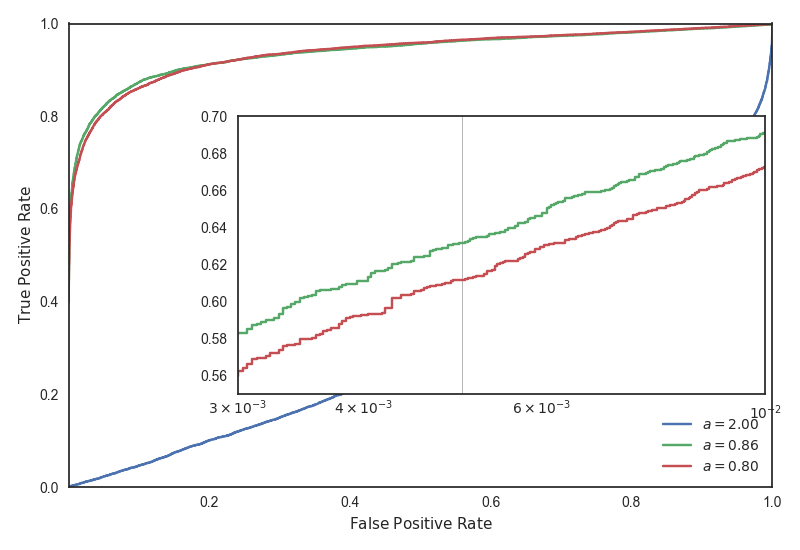

/Users/adamamiller/miniconda3/envs/py36/lib/python3.6/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


In [532]:
a_choice = [2, 0.86, 0.80]

fig, ax = plt.subplots()

axins = inset_axes(ax, width="75%",  
                   height="60%", loc=7)

for a in a_choice:
    fpr, tpr, thre = calc_roc_curve(a, ps1_df.ix[det_mfs]["wwKronFlux"], 
                                    ps1_df.ix[det_mfs]["wwPSFFlux"], 
                                    np.array(ps1_df.ix[det_mfs]["mu_class"], dtype = int)-1)
    ax.plot(fpr, tpr, label = r"$a = {:.2f}$".format(a))
    axins.plot(fpr, tpr)

axins.plot([5e-3,5e-3], [0,1], '0.6', lw = 0.5, zorder = -10)
    
# ax.set_yscale("log")
# ax.set_xscale("log")
ax.set_xlim(1e-3,1)
ax.set_ylim(1e-3,1)
ax.set_xlabel(r"$\mathrm{False\;Positive\;Rate}$")
ax.set_ylabel(r"$\mathrm{True\;Positive\;Rate}$")

axins.set_xlim(3e-3, 1e-2)
axins.set_ylim(0.55, 0.7)
axins.set_xscale("log")
# axins.set_yscale("log")
# axins.set_xlabel(r"$\mathrm{FPR}$")
# axins.set_ylabel(r"$\mathrm{TPR}$")

ax.legend()
fig.tight_layout()